<a href="https://colab.research.google.com/github/fernanda0402/Doutorado/blob/main/Gaussian_Process_H(z).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos utilizar o Gaussian Process GaPP para trabalhar com dados de $H(z)$. Primeiramente, vamos importar e instalar as bibliotecas necessárias.

In [1]:
# Bibliotecas:

import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy.interpolate as interp
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.optimize import curve_fit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pyccl

✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['pyccl']

conda-forge/linux-64                                        Usin

In [4]:
import pyccl as ccl

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/JCGoran/GaPP@feature/python3#GaPP
from gapp import gp
from numpy import loadtxt, savetxt

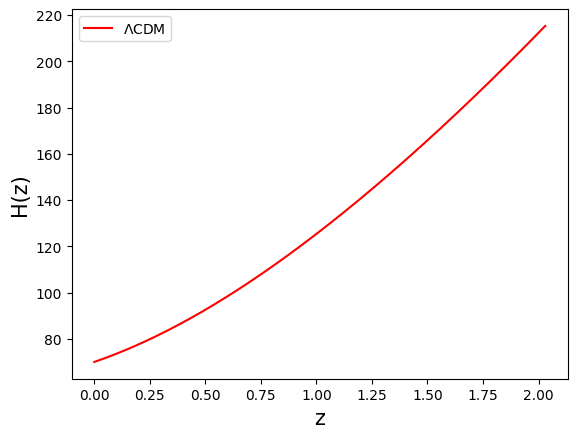

In [34]:
# MODELO LCDM
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.33, 1, 1000)  # fator de escala

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

h_lcdm = ccl.h_over_h0(cosmo, a)

h0 = 70 #km/s/Mpc

h_new = h_lcdm * h0

plt.plot(z, h_new, color='red', label='$\Lambda$CDM')
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.show()

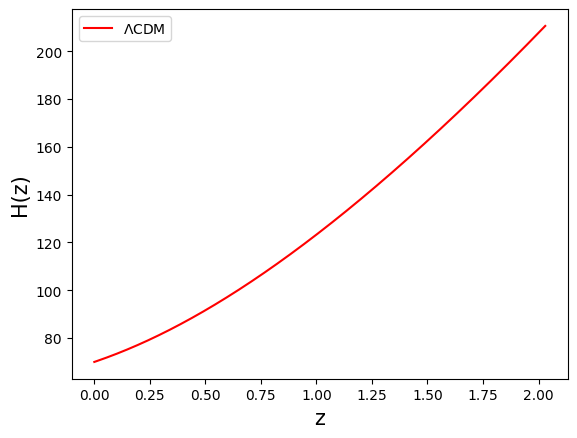

In [35]:
# outra forma de escrever H(z)

# constantes
Om0 = 0.30
O_L0 = 1 - Om0
h0 = 70 #km/s/Mpc


h_1 = h0*(np.sqrt(Om0*((1+z)**3) + O_L0 ))

plt.plot(z, h_1, color='red', label='$\Lambda$CDM')
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.show()

Vamos fazer a derivada do modelo $\Lambda$CDM.


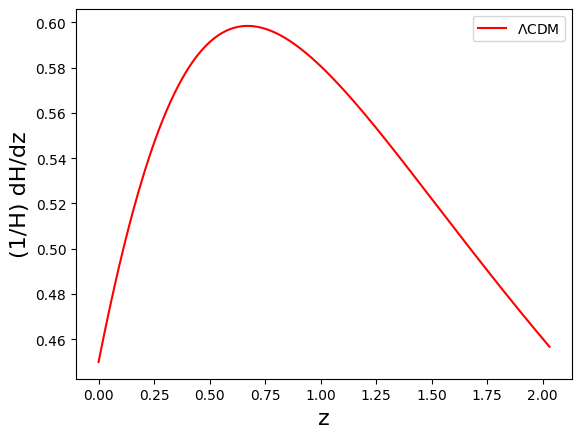

In [38]:
# constantes
Om0 = 0.30
O_L0 = 1 - Om0
h0 = 70 #km/s/Mpc

dh_lcdm = ( (3/2)*h0*Om0*((1+z)**2) )/(np.sqrt(Om0*((1+z)**3) + O_L0 ))

dh_new = ( (3/2)*Om0*((1+z)**2) )/(Om0*((1+z)**3) + O_L0 )

# plote

plt.plot(z, dh_new, color='red', label='$\Lambda$CDM')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Agora, vamos baixar os dados.


Optimized hyperparameters:
theta = [134.94426242   1.98775665]


<ipython-input-15-fdd8d80b536e>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')


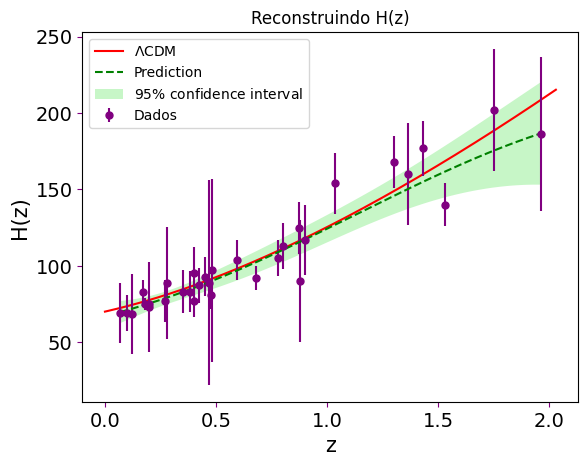

In [15]:
# baixando os dados
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/CC_Hz_data.csv', delimiter=', ')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 1000

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval 
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.plot(z, h_new, color='red', label='$\Lambda$CDM')
plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo H(z)')
plt.show()



# salvando os dados reconstruídos

H = xi, y_pred, sigma
np.savetxt('hz_recon.dat', np.transpose(H), delimiter='\t')
#from google.colab import files
#files.download("hz_recon.dat")

Vamos fazer a primeira derivada usando o GaPP.

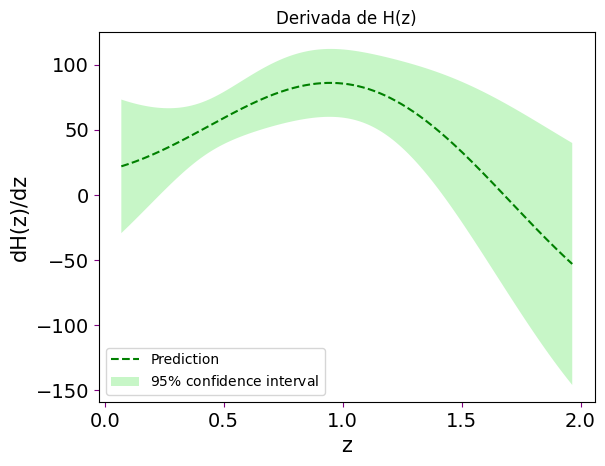

In [17]:
from gapp import dgp # dgp calcula a primeira, segunda e terceira derivada

# baixando os dados
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/CC_Hz_data.csv', delimiter=', ')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 1000

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(thetatrain='False')

# the second and third derivatives use g.d2gp() and g.d3gp()

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma



# Plot the function, the prediction and the 95% confidence interval 
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('dH(z)/dz', fontsize=15)
plt.legend(loc='best')
plt.title('Derivada de H(z)')
plt.show()

# salvando os dados reconstruídos

dH = xi, y_pred, sigma
np.savetxt('dhz_recon.dat', np.transpose(dH), delimiter='\t')
#from google.colab import files
#files.download("dhz_recon.dat")

Porém, o que realmente queremos plotar é a razão $\frac{1}{H(z)} \frac{dH}{dz}$.

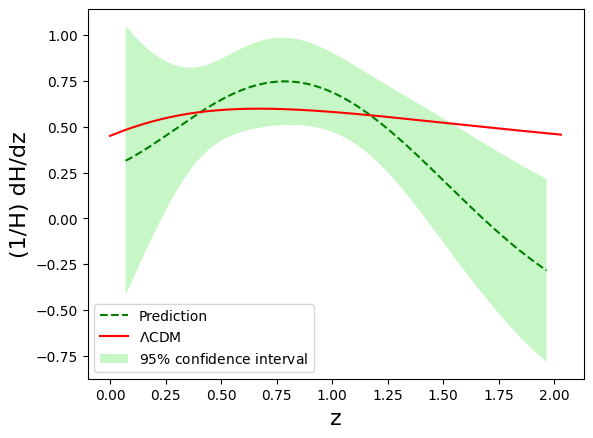

In [39]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

hz = np.genfromtxt('/content/hz_recon.dat', delimiter='\t')

z_hz = hz[:, 0]
h_hz = hz[:, 1]

ehz = hz[:, 2]

dhz = np.genfromtxt('/content/dhz_recon.dat', delimiter='\t')

dh = dhz[:, 1]

edh = dhz[:, 2]

dh_h = dh / h_hz

sigma = np.sqrt(((dh_h) ** 2) * (((ehz / h_hz) ** 2) + ((edh / dh) ** 2)))


# PLOTE
plt.plot(z_hz, dh_h, color='green', label='Prediction', linestyle="--")
plt.plot(z, dh_new, color='red', label='$\Lambda$CDM')
plt.fill(np.concatenate([z_hz, z_hz[::-1]]),
         np.concatenate([dh_h - 1.9600 * sigma,
                        (dh_h + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()